# The Stack Overflow Community: An Analysis Before and After Pandemic

For this post, I was interestested in using Stack Overflow data from 2018, 2019, 2020 and 2021 for answering the following questions: 

1. Could the pandemic possibly have affected the Employment Status of programmers worldwide?

2. Are there more programmers breaking into the field because of job opportunies created during the pandemic?

3. Are the results for questions (1) and (2) different for respondents from countries whose economies were severely impaired?


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

## Section 0: Declaration of functions and variables

In [71]:
# Declare parameters
# Paths
paths = ['./survey_results_public_2018.csv','./survey_results_public_2019.csv',
         './survey_results_public_2020.csv','./survey_results_public_2021.csv']

# Years
years = [2018,2019,2020,2021]

# Column labels per year
labels = [['Employment','YearsCoding','Salary','Country','Student'],
          ['Employment','YearsCode','CompTotal','Country','Student'],
          ['Employment','YearsCode','CompTotal','Country','MainBranch'],
          ['Employment','YearsCode','CompTotal','Country','MainBranch']]

# 'Employment' categoricals remap
remapEmployment = {
    'Employed full-time':'Full-time',
    'Employed part-time':'Part-time',
    'Not employed, and not looking for work':'Not employed',
    'Not employed, but looking for work':'Not employed',
    'Independent contractor, freelancer, or self-employed':'Self-employed',
    'Retired':'Retired',
    'Student':'Student',
    'Student, full-time':'Student',
    'Student, part-time':'Student'}

# 'Employment' categoricals
employmentLabels = list(set(remapEmployment.values()))

# 'YearsCoding' categoricals 
binLabel = ['0-2 years','3-5 years','6-8 years',
            '9-11 years','12-14 years','15-17 years',
            '18-20 years','21-23 years','24-26 years',
            '27-29 years','30 or more years']

# Countries severely affected by the COVID-19 pandemic
mostEconomicallyAffected = ['Brazil','Panama','Angola','Zambia','Namibia']

# Empty dataframes for further analysis
countEmployment = pd.DataFrame(index=employmentLabels)
countYearsCoding = pd.DataFrame(index=binLabel)
countEmploymentAffected = pd.DataFrame(index=employmentLabels)
countYearsCodingAffected = pd.DataFrame(index=binLabel)

In [72]:
# Declare functions
# ImportDataframe
def ImportDataframe(path):
    '''
    This function reads a dataframe from a specific directory
    INPUT - path - string - path of the dataframe
    OUTPUT - df - pandas dataframe
            
    '''    
    df = pd.read_csv(path,low_memory=False)   
    return df

# CreateSubDataframe
def CreateSubDataframe(df,label):
    '''
    This function creates a data subset from specific columns
    INPUT - df - pandas dataframe
          - label - list of strings - desired columns' labels
    OUTPUT - df - pandas dataframe
            
    '''    
    try:
        df = df[label]   
    except:
        return df
    return df

# RenameColumn
def RenameColumn(df,label):
    '''
    This function renames specific columns
    INPUT - df - pandas dataframe
          - label - list of strings - old columns' labels
    OUTPUT - df - pandas dataframe
            
    '''  
    df.rename(columns={label[0]: 'Employment', label[1]: 'YearsCoding', label[2]: 'Salary'},inplace=True)
    return df

# CreateYearColumn
def CreateYearColumn(df,year):
    '''
    This function creates a new column named Year
    INPUT - df - pandas dataframe
          - year - list of integers
    OUTPUT - df - pandas dataframe
            
    '''
    df['Year'] = year
    return df

# dropNanColumns
def dropNanColumns(df):
    '''
    This function drop the columns completely filled with NaN values, in case there is any
    INPUT - df - pandas dataframe
          - year - list of integers
    OUTPUT - df - pandas dataframe
            
    '''
    df = df.dropna(how='all', axis=1)  
    return df

# PlotSpecs
def PlotSpecs(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE):
    '''
    This function sets the plot specifications
    INPUT - SMALL_SIZE - integer - small font size
          - MEDIUM_SIZE - integer - medium font size
          - BIGGER_SIZE - integer - big font size
    OUTPUT - colorArray - list 
            
    '''
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    colorArray = [plt.cm.tab20(0),plt.cm.tab20(6),plt.cm.tab20(13),plt.cm.tab20(19)]
    return colorArray

# IsAffectedCountry
def IsAffectedCountry(country):
    '''
    This function returns 1 if 'country' is in 'mostEconomicallyAffected', and 0 otherwise
    INPUT - country - string
    OUTPUT - bool 
            
    '''
    if country in mostEconomicallyAffected: return 1
    else: return 0

# Num2Bin
def Num2Bin(string):
    '''
    This function converters a string to a predefined set of bins for creation of a histogram.
    INPUT - yearsCoding - string 
    OUTPUT - string - bin 
    '''
    try:
        num = int(string) 
        if (num <= 2):
            return '0-2 years'
        elif ((num >= 3) & (num <= 5)):
            return '3-5 years'
        elif ((num >= 6) & (num <= 8)):
            return '6-8 years'
        elif ((num >= 9) & (num <= 11)):
            return '9-11 years'
        elif ((num >= 12) & (num <= 14)):
            return '12-14 years'
        elif ((num >= 13) & (num <= 17)):
            return '15-17 years'
        elif ((num >= 18) & (num <= 20)):
            return '18-20 years'  
        elif ((num >= 21) & (num <= 23)):
            return '21-23 years'  
        elif ((num >= 24) & (num <= 26)):
            return '24-26 years' 
        elif ((num >= 27) & (num <= 29)):
            return '27-29 years' 
        else:
            return '30 or more years' 
    except:
        if (string == 'Less than 1 year'):
            return '0-2 years'
        elif (string == 'More than 50 years'):
            return '30 or more years'
        else:
            return string

## Section 1: Data Understanding

### Gather Data
Here, data is imported from four Stack Overflow surveys perfomed in 2018, 2019, 2020 and 2021.

In [73]:
# Load dataframes
df = [ImportDataframe(path) for path in paths] 

## Section 2: Prepare Data
In this section, data is prepared and cleaned. 

Preparation involves:
1. Remove columns that will not be analysed 
2. Rename columns for uniformity
3. Create a *'Year'* column
5. Merge dataframes into a single dataframe
6. Remap categoricals in *'Employment'*
7. Ramap *'YearsCoding'* into bins
8. Creat a column with booleans: 1 if *'Country'* is in *'mostEconomicallyAffected'*, 0 otherwise 
9. Create new dataframe containing only respondents from *'mostEconomicallyAffected'*.

Cleaning involves:
1. Drop columns completely filled with NaN values (if any)
2. Impute rows with missing values for column *'Employment'*
3. Impute rows with missing values for column *'YearsCoding'*

Imputation was chosen because:
* *'Employment'* is a categorical column with a small percentage of missing values (1.78 %). For this reason, missing values were imputed and replaced by the mode.
* In 2021, Stack Overflow added the field 'I prefer not to say' in 'Employment' (1.07 % of occurrence),  which was also imputed following the same principle. This was done to improve data uniformity between the years.
* *'Years coding'* is also a categorical column with a small percentage of missing values (4.33 %). The same approach was utilized.

In [84]:
# Create data subsets
df = [CreateSubDataframe(df[i],labels[i]) for i in range(len(years))] 

# Rename columns
df = [RenameColumn(df[i],labels[i]) for i in range(len(years))]

# Create 'year' column
df = [CreateYearColumn(df[i],years[i]) for i in range(len(years))]

# Not necessary: Drop columns with all NaN values
df = [dropNanColumns(df[i]) for i in range(len(years))]

# Merge into a single dataframe
newDf = pd.concat([df[0],df[1],df[2],df[3]],sort=False)

# Dataframe visualization
# newDf.head()

# Calcule percetage of missing values
employmentMissing = newDf.loc[pd.isna(newDf['Employment'])==True].shape[0]*100/newDf.shape[0]
print("Missing in Employment: {v:.2f} %".format(v=employmentMissing))

employmentNTD = newDf.loc[newDf['Employment']=='I prefer not to say'].shape[0]*100/newDf.loc[newDf['Year']==2021].shape[0]
print("NTD in Employment: {v:.2f} %".format(v=employmentNTD))

yearsCodingMissing = newDf.loc[pd.isna(newDf['YearsCoding'])==True].shape[0]*100/newDf.shape[0]
print("Missing in YearsCoding: {v:.2f} %".format(v=yearsCodingMissing))

# Impute missing values in 'Employment' and 'YearsCoding'
newDf['Employment'].fillna(value=newDf['Employment'].mode()[0],inplace=True)
newDf['YearsCoding'].fillna(value=newDf['YearsCoding'].mode()[0],inplace=True)

# Impute 'I prefer not to say' in 'Employment'
newDf['Employment'].replace({'I prefer not to say':newDf['Employment'].mode()[0]},inplace=True)

# Rename categoricals in 'Employment' for uniformity and plot shortening
#newDf['Employment'] = newDf['Employment'].astype('category')
newDf['Employment'].replace(remapEmployment,inplace=True)

# Map bins for uniformity
newDf['YearsCoding'] = newDf['YearsCoding'].apply(Num2Bin)

# Create AffectedCountry flag
newDf['AffectedCountry'] = newDf['Country'].apply(IsAffectedCountry)
newDfSubset = newDf.loc[newDf['AffectedCountry']==1]

# Dataframe visualization
newDf.head()

Missing in Employment: 1.78 %
NTD in Employment: 1.07 %
Missing in YearsCoding: 4.33 %


,Employment,YearsCoding,Salary,Country,Student,Year,MainBranch,AffectedCountry
0,Part-time,3-5 years,NaN,Kenya,No,2018,NaN,0
1,Full-time,30 or more years,51000,United Kingdom,No,2018,NaN,0
2,Full-time,24-26 years,NaN,United States,No,2018,NaN,0
3,Full-time,18-20 years,NaN,United States,No,2018,NaN,0
4,Full-time,6-8 years,260000,South Africa,"Yes, part-time",2018,NaN,0


## Section 3: Evaluation
The proposed questions are evaluated and answered in this section. For this purpose, 3 main steps are followed: Analysis, Visualization and Conclusion.

### Question 1: 
> Could the pandemic possibly have affected the Employment Status of programmers worldwide?

**Analysis**: Analysis of column 'Employment'. Count respondents per categorical data for each year (%). **Visualization**: Create a subplot for each year of survey.

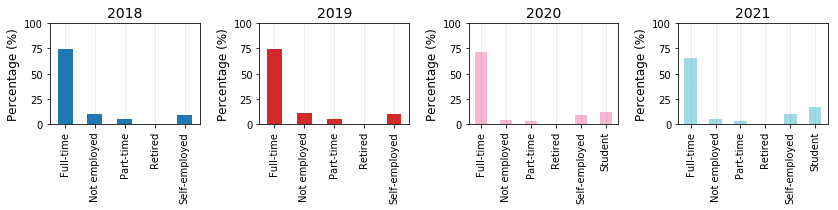

In [75]:
# Set plot specs
colorArray = PlotSpecs(10,12,14)

# Set subplot
fig, axs = plt.subplots(1,4)

# Loop for (1) Analysis and (2) Visualization
for i in range(len(years)):
    # Respondents per categorical
    ax = (newDf.loc[newDf['Year'] == years[i]]['Employment'].value_counts().sort_index()*100
          /newDf.loc[newDf['Year'] == years[i]].shape[0]) 
    
    # Save results
    countEmployment[years[i]] = ax 
    
    # Plot figures
    ax.plot(kind="bar",ax=fig.get_axes()[i],color=colorArray[i])
    fig.get_axes()[i].set_title(str(years[i]))
    fig.get_axes()[i].set_ylim(0,100)
    fig.get_axes()[i].set_ylabel('Percentage (%)')
    fig.get_axes()[i].set_yticks((0,25,50,75,100))
    fig.get_axes()[i].grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)

# Adjust subplots    
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=1.9,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.7)


**Conclusion**: The number of full-time and part-time employed professionals decreased in 2021 comperared to other years. On the other hand, the number of unemployed individuals is smaller in 2020 in comparison with 2018 and 2019. This probably stems from the fact that Stack Overflow only added the ‘Student’ option in 2020 and, before that, students probably addressed themselves as ‘unemployed’. But, when we have a look at the increase of students from 2020 to 2021 , the following question can be raised: were there more people trying to break into the field in 2021?

### Question 2: 
> Are there more programmers breaking into the field because of job opportunies created during the pandemic?

**Analysis**: Analysis of column 'Years Coding'. Count respondents per categorical data for each year (%). **Visualization**: Create a subplot for each year of survey.

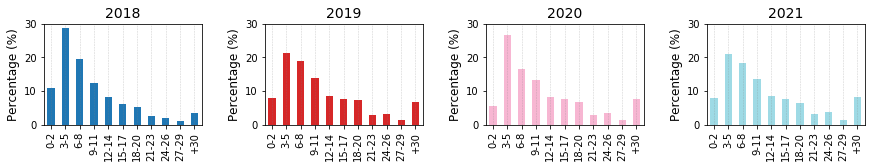

In [76]:
# Set subplot
fig, axs = plt.subplots(1,4)

# Loop for (1) Analysis and (2) Visualization
for i in range(len(years)):
    # Respondents per categorical
    ax = (newDf.loc[newDf['Year'] == years[i]]['YearsCoding'].value_counts()*100
          /newDf.loc[newDf['Year'] == years[i]].shape[0]).reindex(index = binLabel)
    
    # Save results
    countYearsCoding[years[i]] = ax # Save results
    
    # Plot figures
    ax.plot(kind="bar",ax=fig.get_axes()[i],color=colorArray[i])
    fig.get_axes()[i].set_title(str(years[i]))
    fig.get_axes()[i].set_ylim(0,30)
    fig.get_axes()[i].set_ylabel('Percentage (%)')
    fig.get_axes()[i].get_xaxis().set_visible(True)
    fig.get_axes()[i].set_xticklabels(['0-2','3-5','6-8','9-11',
                                       '12-14','15-17','18-20','21-23',
                                       '24-26','27-29','+30'])
    fig.get_axes()[i].grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=2.0,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.7)


**Conclusion**: The percentage of people coding for zero to two years decreased in 2019, showing small deviations in 2020 and 2021. It has never surpressed its maximum value recorded in 2018. Therefore, this evidence points toward denying the proposed question.

### Question 3: 
> Would the conclusions for questions (1) and (2) be different if only respondents from countries severely impaired were analysed?

#### Employment Status Analysis
**Analysis**: Percentage difference between respondants across the globe and respondents from Brazil, Panama, Angola, Zambia, and Namibia. **Visualization**: Vertical bars.

In [77]:
#newDfSubset.loc[newDfSubset['Year'] == 2021].head()

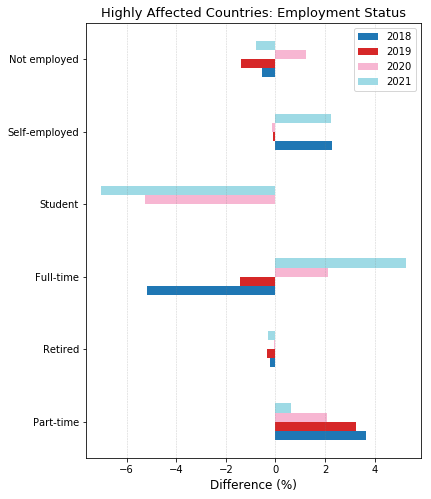

In [78]:
# Create figure
fig = plt.figure(figsize=(6,8))

# Loop for (1) Analysis and (2) Visualization
for i in range(len(years)):
    # Respondents per categorical
    ax = (newDfSubset.loc[newDfSubset['Year'] == years[i]]['Employment'].value_counts().sort_index()*100
          /newDfSubset.loc[newDfSubset['Year'] == years[i]].shape[0])
    
    # Save results
    countEmploymentAffected[years[i]] = ax

# Set NaN values to zero (if any)
countEmploymentAffected.fillna(value=0,inplace=True) 

# Calculate difference
affectedDiff = countEmploymentAffected.subtract(countEmployment)

# Plot figure
affectedDiff.plot.barh(ax=plt.axes(),colormap=plt.cm.tab20)
plt.xlabel('Difference (%)')
plt.title('Highly Affected Countries: Employment Status',fontsize=13)
plt.grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)

**Conclusion**: Considering countries that had their economies severely affected, in 2021 there were more full-time and self-employed professionals, and less students. This possibly indicates more national job opportunities or more programmers applying to remote international vacancies during the pandemic and post-pandemic periods.

#### Years Coding Analysis
**Analysis**: Percentage difference between respondants across the globe and respondents from Brazil, Panama, Angola, Zambia, and Namibia. **Visualization**: Vertical bars.

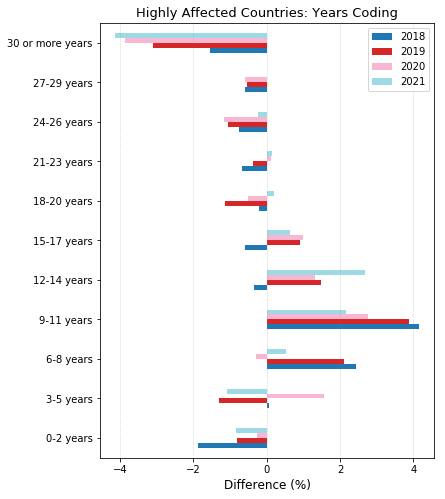

In [79]:
# Create figure
fig = plt.figure(figsize=(6,8))

# Loop for (1) Analysis and (2) Visualization
for i in range(len(years)):
    ax = (newDfSubset.loc[newDfSubset['Year'] == years[i]]['YearsCoding'].
          value_counts()*100/newDfSubset.loc[newDfSubset['Year'] == years[i]].shape[0]) 
    # Save results
    countYearsCodingAffected[years[i]] = ax

# Set NaN values to zero (if any)
countYearsCodingAffected.fillna(value=0,inplace=True)

# Calculate difference
affectedDiff = countYearsCodingAffected.subtract(countYearsCoding)

# Plot figure   
p = affectedDiff.plot.barh(ax=plt.axes(),colormap=plt.cm.tab20)
plt.xlabel('Difference (%)')
plt.title('Highly Affected Countries: Years Coding',fontsize=13)
plt.grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)


**Conclusion**: Less individuals have been recently trying to break into the field compared to the global-scale survey. In addition, Brazil, Panama, Angola, Zambia and Namibia have more developers that have been coding for 6–17 years when compared to the rest of the world.

### Final Conclusion: 
And what can we conclude from the aforementioned analysis? Well, certainly it do not aim to provide an ultimate conclusion, but to show the behaviour of data. Standard deviations are completely normal and can be triggered by a vast range of events. Therefore, further statistical analysis are required to correlate the results to the COVID-19 pandemic.

However, according to the Stack Overflow data, the number of full-time employees decreased in 2021. On the other hand, taking into account only countries whose economies were severely impaired, data indicates that there were more full-time employed and self-employed professionals in 2021 than in the previous years, which could possibly indicate an increse of local job oportunities during and post pandemic.